In [3]:
  from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import sys
sys.path.append('/content/drive/My Drive/Dataset/')

In [4]:
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [9]:
!ls '/content/drive/My Drive/Dataset/'

ls: cannot access '/content/drive/My Drive/Dataset/': No such file or directory


# New Section

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [6]:
pip install bayesian-optimization


In [8]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(3)
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, LeaveOneOut
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input,Dense,concatenate, dot, Dropout, multiply, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.python.keras.callbacks import TensorBoard
from keras.models import model_from_json
from time import time
#from bayes_opt import BayesianOptimization
from functools import partial
from keras import backend as K

import pydot
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import Preprocess
import Evaluate

ModuleNotFoundError: ignored

In [0]:
def data(ratingDatsetLoc):
    ratings = pd.read_csv(ratingDatsetLoc)
    #ratings.drop(columns='timestamp', inplace=True)
    #print(ratings.describe())
    EmbedFile = pd.read_csv("/content/drive/My Drive/Dataset/emb_files/movielens_1m_256.emd", skiprows=1, header=None, sep=' ')
    userEmbedding, movieEmbedding = Preprocess.processEmbeddingData(EmbedFile)
    Rating_Dataset = Preprocess.ratingsReconstruct(userEmbedding, movieEmbedding,ratings)
    #print(Rating_Dataset.head())

    return Rating_Dataset
  

In [0]:
def get_Train_and_Test_Dataset(Rating_Dataset):
  
    # Label = Preprocess.getTarget(Rating_Dataset)
    ''' random split '''
    secondSetofDataset,Label, Time_based_leave_n_outTestSet=Preprocess.timeSplit(Rating_Dataset,2)
    sampleDataTrain, sampleDataTest, labelTrain, labelTest = Preprocess.splitDataset(secondSetofDataset, Label, 0.2)
    # print(Rating_Dataset.head())
    ''' Leave-n-out split'''
    # secondSetofDataset,Label, Time_based_leave_n_outTestSet = Preprocess.leave_n_outSplit(Rating_Dataset,2)
    # sampleDataTrain, sampleDataTest, labelTrain, labelTest = Preprocess.splitDataset(secondSetofDataset, Label, 0.2)

    '''split with val set'''
    #sampleDataTrain, sampleValSet, sampleDataTest, labelTrain, labelValSet, labelTest = Preprocess.customSplitWithValset(Rating_Dataset,0.3,2)
    #userValidation, itemValidation = Preprocess.seperateEntities(sampleValSet)

    #secondSetofDataset, Time_based_leave_n_outTestSet=Preprocess.timeSplit(Rating_Dataset,2)
    ''' cold-start split'''
    #sampleDataTrain, sampleDataTest, labelTrain, labelTest = Preprocess.customDeepCoNNSplit(secondSetofDataset, 0.008, userEmbedding,movieEmbedding)
    userTrain, itemTrain = Preprocess.seperateEntities(sampleDataTrain)
    userTest, itemTest = Preprocess.seperateEntities(sampleDataTest)
    print(userTrain.head())
    #categoricalLabelTrain = keras.utils.to_categorical(labelTrain, num_classes=10, dtype='int32')
    #categoricalLabelTest = keras.utils.to_categorical(labelTest, num_classes=10, dtype='int32')
    #print(userTrain.shape)
    #labelTrain=keras.utils.to_categorical(labelTrain, num_classes=10, dtype='int32')
    #print(userTrain.head())
    
    return userTrain, itemTrain, labelTrain, userTest, itemTest, labelTest,Time_based_leave_n_outTestSet
#     return userTrain, itemTrain, labelTrain, userTest, itemTest, labelTest

In [0]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [0]:
def buildModel(dim,reg_l2,drop):
    units = dim
    user_input = Input(shape=(dim,), name='User')
    ux = Dense(dim, activation='relu')(user_input)
    item_input=Input(shape=(dim,), name='Item')
    ix = Dense(dim,  activation='relu')(item_input)  #bias_regularizer=tf.keras.regularizers.l2(0.01)
    #concat = concatenate([ux,ix])
    #y = dot([ux,ix])
    #concat = multiply([ux,ix])
    concat = dot([ux, ix], axes=1,normalize=True)
    y = Dense(units, activation='relu')(concat)
    y = Dropout(drop)(y)
    y = Dense((units* 0.75), activation='relu')(y)
    y = Dropout(drop)(y)
    y = Dense((units * 0.5), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_l2))(y)
    y = Dropout(drop)(y)
    y = Dense((units*0.25), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_l2))(y)
    y = Dropout(drop)(y)
    y = Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_l2))(y)
    output = Dense(1, name='output')(y)
    model = Model(inputs=[user_input, item_input], outputs=[output])
#     tensorboard = TensorBoard(log_dir="logs/{}" .format(time()))

    return model

In [0]:
def buildModelCustom(dim,reg_l2,drop):
    units = dim*1.5
    user_input = Input(shape=(dim,), name='User')
    ux = Dense(dim, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_l2))(user_input)
    item_input=Input(shape=(dim,), name='Item')
    ix = Dense(dim,  activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_l2))(item_input)  #bias_regularizer=tf.keras.regularizers.l2(0.01)
    #concat = concatenate([ux,ix])
    #y = dot([ux,ix])
    #concat = multiply([ux,ix])
    concat = dot([ux, ix], axes=1,normalize=True)
    y = Dense(units, activation='relu')(concat)
    y = Dropout(drop)(y)
    y = BatchNormalization()(y)
    y = Dense((units), activation='relu')(y)
    y = Dropout(drop)(y)
    y = BatchNormalization()(y)
    y = Dense((units), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_l2))(y)
    y = Dropout(drop)(y)
    y = BatchNormalization()(y)
    y = Dense((units), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_l2))(y)
    y = Dropout(drop)(y)
    y = BatchNormalization()(y)
    y = Dense((units), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_l2))(y)
    y = Dropout(drop)(y)
    y = BatchNormalization()(y)
    y = Dense((units), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_l2))(y)
    y = Dropout(drop)(y)
    y = BatchNormalization()(y)
    y = Dense((units), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_l2))(y)
    y = Dropout(drop)(y)
    y = BatchNormalization()(y)
    y = Dense((units), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_l2))(y)
    y = Dropout(drop)(y)
    y = BatchNormalization()(y)
    y = Dense((units), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_l2))(y)
    y = Dropout(drop)(y)
    y = BatchNormalization()(y)
    y = Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_l2))(y)
    output = Dense(1, name='output')(y)
    model = Model(inputs=[user_input, item_input], outputs=[output])
    #tensorboard = TensorBoard(log_dir="logs/{}" .format(time()))

    return model


In [0]:
def save_model(RS_model,filename, indicator):
    if indicator == "normal":
        RS_model.save("/content/drive/My Drive/Dataset/2nd_trained_model/%s" %filename)
        print("Model saved to disk")
    if indicator == "json":
        #serialize model to json
        model_json=RS_model.to_json()
        with open("model.json", "w") as json_file:
            json_file.write(model_json)
        #serialize weights to HDF5
        RS_model.save_weights("model.h5")
        print("Saved model to disk")

def load_RS_model(model_name, indicator):
    if indicator == "normal":
        model=load_model(model_name, custom_objects={'root_mean_squared_error': root_mean_squared_error})
        print("Loaded model from disk successfully")
    if indicator == "json":
        json_file = open(model_name, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model = model_from_json(loaded_model_json)
        # load weights into new model
        model.load_weights("model.h5")
        print("Loaded model from disk successfully")
    return model


In [0]:
def optimizeBayesian(init_point, iterations):
    fit_with_partial = partial(fitModel,dim)
    # #"dropout":(0.1, 0.2),
    pbounds = {
           "drop":(0.1, 1),
           #"decay":(0.01, 0.0001),
           #"init_Lrate":(0.9, 0.01),
           "reg_l2":(0.1, 0.001)}
    optimizer = BayesianOptimization(
        f=fit_with_partial,
        pbounds=pbounds,
        random_state=1
    )
    optimizer.maximize(init_points=init_point, n_iter=iterations)

    for i, res in enumerate(optimizer.res):
        print("Iteration {}: \n\t{}".format(i, res))

    print("Max optimized\n")
    print(optimizer.max)


Iteration 0: 
	{'target': 0.7597718465028918, 'params': {'drop': 0.47531980423231657, 'reg_l2': 0.028687875149226355}}
  
Iteration 1: 
	{'target': 0.7491567442412062, 'params': {'drop': 0.1001029373356104, 'reg_l2': 0.07006907530944786}}
  
Iteration 2: 
	{'target': 0.7849222581186889, 'params': {'drop': 0.23208030173540176, 'reg_l2': 0.09085847911788902}}

In [0]:
def fitModel(dim, drop, reg_l2): #init_Lrate,decay
    RS_model = buildModel(dim,reg_l2,drop)
#     RS_model = buildModelCustom(dim,reg_l2,drop)

    adam = optimizers.Adam(lr=0.01)
    RS_model.compile(loss='mse', optimizer=adam,metrics=['mae',root_mean_squared_error,  'acc'])
    print(RS_model.summary())
    RS_model.fit([userTrain, itemTrain], labelTrain, batch_size=1000,
                           epochs=20, verbose=1, validation_split=0.40
                    )  # batch_size=1000 callbacks=[tensorboard]
    score = RS_model.evaluate([userTrain, itemTrain], labelTrain, verbose=0)
    print(RS_model.metrics_names)
    print('Test MSE loss:', score[0])
    print('Test MAE:', score[1])
    print('RMSE', score[2])

    predicted = RS_model.predict([userTest, itemTest])
    Evaluate.testModel(RS_model,labelTest, userTest, itemTest)

    #return score[0]
    return RS_model

In [0]:
loc_data_csv= "/content/drive/My Drive/Dataset/movielens_ratings_1m.csv"
#df=pd.read_csv(loc_data_csv)

In [0]:
data_with_Embedding = data(loc_data_csv)
userTrain, itemTrain, labelTrain, userTest, itemTest, labelTest,Time_based_leave_n_outTestSet = get_Train_and_Test_Dataset(data_with_Embedding)
# userTrain, itemTrain, labelTrain, userTest, itemTest, labelTest = get_Train_and_Test_Dataset(data_with_Embedding)
# userTrain.to_csv('/content/drive/My Drive/Dataset/train_test_Set/movielens_ratings_1m_userTrain.csv')
# userTrain.to_csv('/content/drive/My Drive/Dataset/train_test_Set/movielens_ratings_1m_itemTrain.csv')
userTrain.to_csv('/content/drive/My Drive/Dataset/train_test_Set/movielens_ratings_1m_labelTrain.csv')
userTrain.to_csv('/content/drive/My Drive/Dataset/train_test_Set/movielens_ratings_1m_userTest.csv')
userTrain.to_csv('/content/drive/My Drive/Dataset/train_test_Set/movielens_ratings_1m_itemTest.csv')
userTrain.to_csv('/content/drive/My Drive/Dataset/train_test_Set/movielens_ratings_1m_labelTest.csv')
userTrain.to_csv('/content/drive/My Drive/Dataset/train_test_Set/movielens_ratings_1m_Time_TestSet.csv')






#dim = userTrain.shape[1]


In [0]:
RS_model=fitModel(dim,0.1, 0.0005) #, 0.48633, 0.01

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
User (InputLayer)               [(None, 256)]        0                                            
__________________________________________________________________________________________________
Item (InputLayer)               [(None, 256)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          65792       User[0][0]                       
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          65792       Item[0][0]                       
_____________

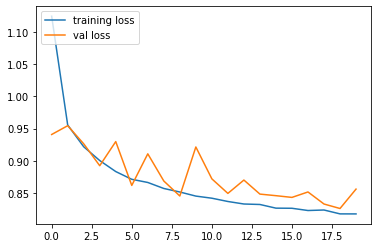

In [0]:
history=RS_model.history
plt.figure("Loss")
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend(loc='upper left')
plt.show()

#predictedValue = RS_model.predict([userTest, itemTest])
#Evaluate.testModel(RS_model,labelTest, userTest, itemTest)

In [0]:
pip install ipynb


In [0]:
from ipynb.fs.full.Evaluate_model.ipynb import Precision1
Precision1(data_with_Embedding,RS_model,1000)


In [0]:
save_model(RS_model,"rs_bookz_model.h5",'normal')
#save_model(RS_model,'json')

In [0]:
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform



In [0]:
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
  RS_model1=tf.keras.models.load_model("/content/drive/My Drive/Dataset/2nd_trained_model/rs_1m_ml_model.h5", custom_objects={'root_mean_squared_error': root_mean_squared_error})

In [0]:
Evaluate.testModel(RS_model1,labelTest, userTest, itemTest)

In [0]:
def getUserItemEmbeddings(Dataset, uid,index):
    userList = Dataset.loc[:, Dataset.columns.str.contains('u')].copy()
    userList.drop(columns='userId', inplace=True)
    uniqueUserList = userList.loc[index]
    unseenItems=Dataset.loc[Dataset['userId']!=uid, :].sample(n=99, replace=False, random_state=5)
    unseenItems=unseenItems.append(Dataset.loc[index])
    movieList=unseenItems.loc[:, unseenItems.columns.str.contains('m')].copy()
    uniqueMovieList = movieList.drop_duplicates('movieId', keep='first')
    return [uniqueUserList, uniqueMovieList]

def topNpredictions(uniqueUserList,uniqueMovieList, N, Rmodel):
    uEmbed=np.asarray(uniqueUserList)
    prediction=pd.DataFrame(columns=['movieId','predicted_rating'])
    count=0
    for row in uniqueMovieList.itertuples():
        count+=1
        prediction.loc[count,'movieId']=mid=row[1]
        mEmbed=np.asarray(row[3:259])
        prediction.loc[count, 'predicted_rating']=np.round(Rmodel.predict([uEmbed.reshape(256,1).T, mEmbed.reshape(256,1).T]),1)

    prediction.sort_values(by='predicted_rating',ascending=False,inplace=True)
    return(prediction.head(N))

def hitRate(leftoutpredictions, Dataset, N, Rmodel):
    hits = 0
    total = 0

    for leftout in leftoutpredictions.itertuples():
        uid = leftout[1]
        leftoutmovieid = leftout[2]
        userEmbedding, movieEmbedding = getUserItemEmbeddings(Dataset,uid,leftout[0])
        hit = False
        #getRandom_k_prediction(uid,testSet, 10, model)
        topNpredicted=topNpredictions(userEmbedding, movieEmbedding,N, Rmodel)
        
        for index, row in topNpredicted.iterrows():
            if (row['movieId'] ==leftoutmovieid):
                hit = True
        if (hit):
            hits += 1
        total += 1
        print(hits / total)
    return hits / total

def rel(row):
    count=0
    if row[2]>=3.5 and row[1]>3.5:
       count+=1
    return count

def rec_and_rel(row,n):
    if row[n]>=3.5:
        return 1
    else:
        return 0


In [0]:

def Precision(Dataset, model,sample_size):
    '''
    A relevant item is an item that the user actually rated >=3.5
    A recommended item is an item recommended by the algorithm with a predicted rating rating >=3.5
    Recall@k = (# of recommended items @k that are relevant) / (total # of relevant items)
    Precision@k = (# of recommended items @k that are relevant) / (# of recommended items @k)
    '''

    userList = Dataset.loc[:, Dataset.columns.str.contains('u')].copy()
    uniqueUsers=userList.drop_duplicates('userId', keep='first')
    movieList = Dataset.loc[:, Dataset.columns.str.contains('m')].copy()
    uniqueMovie = movieList.drop_duplicates('movieId', keep='first')
    predictions = pd.DataFrame(columns=['movieId','predicted_rating', 'actual_rating'])

    precision=0
    sampleUniqueUsers=uniqueUsers.sample(n=sample_size, replace=False, random_state=5)      # samples the user set
    users_precision=pd.DataFrame(columns=['userId', 'precision_at_10'])
    for row in sampleUniqueUsers.itertuples():
        uid=row[1]
        uEmbed=np.asarray(row[2:258])
        count=0
        users_precision.at[count,'userId']=uid
        for m_row in uniqueMovie.itertuples():                                            #make predictions for each user, one at a time, over all itemset
            count+=1
            mid=m_row[1]
            mEmbed=np.asarray(m_row[3:259])
            predictions.loc[count,'movieId']= mid
            x=np.round(model.predict([uEmbed.reshape(256,1).T, mEmbed.reshape(256,1).T]))
            predictions.loc[count,'predicted_rating']=x

        predictions.sort_values(by='predicted_rating',ascending=False,inplace=True)     #select topN predictions
        topN=predictions.head(10)
        for item in topN.itertuples():                                              #get actual rating for topN item where available
            i=item[0]
            data = Dataset.query('movieId==@item[1] and userId==@uid')
            if data.empty==False:
                topN.at[i,'actual_rating']= data.rating.values
        #print(topN.head(10))
        y = np.sum(topN.apply(rel,axis=1))                                          #count items that are relevant and recommended
        users_precision.at[count, 'precision_at_10'] = y/10
        precision=precision+(y/10)
        print(precision)
    MAP=precision/sample_size
    print(MAP)
        #recall=np.sum(topN.apply(rec_and_rel,n=1,axis=1))
        #sum_relevant=np.sum(topN.apply(rec_and_rel,n=2,axis=1))
        #sum_relevant=Dataset.groupby('userId')['itemId']
        #print(recall/sum_relevant)


In [0]:
def Precision1(Dataset, model, sample_size):
    '''
    A relevant item is an item that the user actually rated >=3.5
    A recommended item is an item recommended by the algorithm with a predicted rating rating >=3.5
    Recall@k = (# of recommended items @k that are relevant) / (total # of relevant items)
    Precision@k = (# of recommended items @k that are relevant) / (# of recommended items @k)
    '''
    userList = Dataset.loc[:, Dataset.columns.str.contains('u')].copy()  # Get all user embedding columns and user id
    uniqueUsers = userList.drop_duplicates('userId', keep='first')  # remove duplicates
    movieList = Dataset.loc[:, Dataset.columns.str.contains('m')].copy()  # Get all movie embedding columns and movie id
    uniqueMovie = movieList.drop_duplicates('movieId', keep='first')  # remove duplicates
    #uniqueMovie.drop(columns='timestamp', inplace=True)
    mEmbed = np.asarray(uniqueMovie.iloc[:,2:259])
    predictions = pd.DataFrame(columns=['movieId', 'predicted_rating', 'actual_rating'])  # creates table to hold predicted items

    precision = 0
    recall=0
    sampleUniqueUsers = uniqueUsers.sample(n=sample_size, replace=False, random_state=5)  # samples the user set
    users_precision = pd.DataFrame(columns=['userId', 'precision_at_10', 'recall_at_10'])  # create table to hold precision at 10 for each user
    len = uniqueMovie.shape[0]
    for row in sampleUniqueUsers.itertuples():  # loop through each user
        uid = row[1]  # Get user id
        uEmbed = np.expand_dims(np.asarray(row[2:258]), axis=0) # Get the embedding vector of user
        count = 0
        users_precision.at[count, 'userId'] = uid
        uEmbed_repeated = np.repeat(uEmbed, repeats=len, axis=0)
        uniqueMovieId=uniqueMovie.iloc[:,0:1]
        uniqueMovieId['predicted'] = np.round(model.predict([uEmbed_repeated, mEmbed]))
        uniqueMovieId.sort_values(by='predicted', ascending=False, inplace=True)
        topPredicted10=uniqueMovieId.head(10).copy()                                               #get top 10 recommendation

        actual_rating = []
        for item in topPredicted10.itertuples():                                              #get actual rating for topN item where available
            i=item[0]
            data = Dataset.query('movieId==@item[1] and userId==@uid')
            if data.empty==False:
                actual_rating.append(data.rating.values)
            else:
                actual_rating.append(np.nan)
        topPredicted10['actual_rating']=actual_rating
        print(topPredicted10.head(10))
        y = np.sum(topPredicted10.apply(rel, axis=1))                                   #count items that are relevant and recommended
        users_precision.at[count, 'precision_at_10'] = y / 10                           #store value of precision for usre
        r=np.sum(topPredicted10['actual_rating'].apply(rec_and_rel))
        if r>0:
            users_precision.at[count, 'recall_at_10'] = y / r                           #store value of recall for user
        else:
            r=1
            users_precision.at[count, 'recall_at_10'] = y / r
        precision = precision + (y / 10)

        recall = recall + (r / 10)
        print(precision)
        print(recall)
    MAP = precision / sample_size
    MAR = recall/sample_size
    print(MAP)
    print(MAR)




In [0]:
HR_at_N = hitRate(Time_based_leave_n_outTestSet, data_with_Embedding,10,RS_model1)

In [0]:
Precision(data_with_Embedding,RS_model1,100)


In [0]:
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(RS_model1).create(prog='dot', format='svg'))

In [0]:
from keras.utils import plot_model
tf.keras.utils.plot_model(RS_model1, to_file='model.png')

In [0]:
test_label = labelTest
test_predictions = RS_model1.predict([userTest, itemTest])
predictions_label = np.round(test_predictions)
print(np.round(test_predictions), 1)


[[4.]
 [4.]
 [5.]
 ...
 [3.]
 [4.]
 [4.]] 1
(197626,)
(197626, 1)


In [0]:
r=np.array(test_label)
print(len(r))
t=np.array(predictions_label[:,0])
print(len(t))

197626
197626


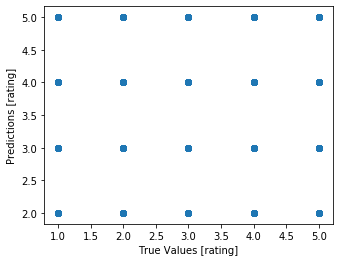

In [0]:

# plt.scatter(test_label, predictions_label)
# plt.xlabel('True values [rating]')
# plt.ylabel('Predictions [rating]')
# plt.axis('equal')
# plt.axis('square')
# plt.xlim([0,plt.xlim()[1]])
# plt.ylim([0,plt.ylim()[1]])
# _= plt.plot([-100, 100],[-100, 100])

a = plt.axes(aspect='equal')
plt.scatter(r, t)
plt.xlabel('True Values [rating]')
plt.ylabel('Predictions [rating]')
plt.show()
# lims = [-1, 6]
# plt.xlim(lims)
# plt.ylim(lims)
# _ = plt.plot(lims, lims)
